In [1]:
import pickle
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 2000000000
import rasterio
import numpy as np

address = "Area_jamkhed/0/"
input_image_path = address + '/field.tif'
image = Image.open(input_image_path)
#ts_image = rasterio.open("Area_orans_1/TS_Area_oran_1_2023-2024.tif")
#ts_image = ts_image.read([i for i in range(1,24)])
#ts_image = np.transpose(ts_image, (2,1,0))

with open(address + '/instance_predicted.pickle', 'rb') as handle:
    instances_predicted = pickle.load(handle)
    instances_predicted = instances_predicted.T
    
segments = instances_predicted.max()

In [2]:
min_i = {}
min_j = {}
max_i = {}
max_j = {}
printcounter = 0
for i in range(instances_predicted.shape[0]):
    if printcounter == 1000:
        print(i)
        printcounter=0
    printcounter+=1
    for j in range(instances_predicted.shape[0]):
        val = instances_predicted[i][j]
        if val not in min_i:
            min_i[val] = i
        if val not in max_i:
            max_i[val] = i
        if val not in min_j:
            min_j[val] = j
        if val not in max_j:
            max_j[val] = j
        min_i[val] = min(i, min_i[val])
        min_j[val] = min(j, min_j[val])
        max_i[val] = max(i, max_i[val])
        max_j[val] = max(j, max_j[val])     

1000
2000
3000
4000


In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk, ball
from sklearn.decomposition import PCA

def crop_image_by_mask(image, index):
    # Find the bounding box of the True values in the mask
    min_x, min_y, max_x, max_y = min_j[index], min_i[index], max_j[index], max_i[index]
    # Crop the image using the bounding box
    cropped_image = image.crop((min_x, min_y, max_x + 1, max_y + 1))
    # Crop the mask as well
    cropped_mask = instances_predicted[min_y:max_y + 1, min_x:max_x + 1]
    cropped_mask = cropped_mask==index
    # Convert the cropped image to RGBA (if not already)
    cropped_image = cropped_image.convert("RGBA")
    # Get pixel data
    pixels = np.array(cropped_image)
    # Set pixels where the mask is False to transparent
    pixels[~cropped_mask] = [0, 0, 0, 0]  # Set to transparent
    # Convert back to an image
    masked_image = Image.fromarray(pixels)
    return masked_image, cropped_mask, (min_x, min_y, max_x, max_y)

def get_entropy(img, mask):
    ent = entropy(np.asarray(img.convert('L')).copy(), disk(5), mask=mask)
    ent = ent[ent>5.2]
    ent = sum(ent)/(sum(sum(mask)))
    return ent

def get_entropy_plantation(img, mask):
    ent = entropy(np.asarray(img.convert('L')).copy(), disk(30), mask=mask)
    ent = ent[ent>0]
    ent = sum(ent)/(sum(sum(mask)))
    return ent

def get_rectangularity(mask) -> float:
    """
    Compute how rectangular a given binary mask is.
    
    Args:
        mask (np.ndarray): Binary mask (1 for object, 0 for background)
    
    Returns:
        float: Rectangularity score (1.0 is a perfect rectangle, lower means less rectangular)
    """
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return 0  # No object found
    
    # Get the largest contour
    contour = max(contours, key=cv2.contourArea)
    
    # Compute contour area
    contour_area = cv2.contourArea(contour)
    
    # Compute bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    bounding_rect_area = w * h
    
    if bounding_rect_area == 0:
        return 0  # Avoid division by zero
    
    # Compute rectangularity score
    rectangularity_score = contour_area / bounding_rect_area
    
    return rectangularity_score

def get_perimeter_area_fractal_dimension(mask):
    # Load the image
    _, binary = cv2.threshold(mask.astype(np.uint8)*255, 128, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None  # No shape detected

    # Assume the largest contour is the shape
    contour = max(contours, key=cv2.contourArea)

    # Compute area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Compute fractal dimension
    if area > 0:
        D = 2 * (np.log(perimeter) / np.log(area))
        return D
    else:
        return None

def get_ht_lines(img, mask):
    masked_image_np = np.array(img.convert("L"))
    #masked_image_np = cv2.bilateralFilter(masked_image_np,3,75,75)
    #_, binary_image = cv2.threshold(masked_image_np, 50, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(masked_image_np, 50, 150)
    erosion_size = 3
    # Define the kernel for erosion
    kernel = np.ones((erosion_size, erosion_size), np.uint8)
    # Erode the mask to remove edge pixels
    eroded_mask = cv2.erode(mask.astype(np.uint8) * 255, kernel, iterations=1)
    #print(index)
    edges = cv2.bitwise_and(edges, edges, mask=eroded_mask)
    # Perform Hough Line Transformation
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=30)
    detected_lines = []
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            detected_lines.append(((x1, y1), (x2, y2)))
    
    return detected_lines

from itertools import combinations
def calculate_angle(line1, line2):
    def line_angle(line):
        (x1, y1), (x2, y2) = line
        return np.degrees(np.arctan2(y2 - y1, x2 - x1))
    
    angle1 = line_angle(line1)
    angle2 = line_angle(line2)
    
    # Calculate absolute angle difference
    angle_diff = abs(angle1 - angle2)
    
    # Ensure the angle is within 0-180 degrees range
    return min(angle_diff, 180 - angle_diff)

def check_right_angles(lines, tolerance=5):
    right_angle_pairs = []
    for line1, line2 in combinations(lines, 2):
        angle = calculate_angle(line1, line2)
        if abs(angle - 90) <= tolerance:
            right_angle_pairs.append((line1, line2, angle))
    
    return right_angle_pairs
ndvis = {}
label = {}
rest_ndvi = []
for index in range(3384,3386):
    img, mask, croping_indexes = crop_image_by_mask(image, index)
    min_x,min_y,max_x,max_y = croping_indexes
    #print(croping_indexes)
    #ts = resized_ts[min_y:max_y + 1, min_x:max_x + 1].copy()
    #ts[~mask]=0
    #mean_ndvi = np.mean(ts, axis=(0,1))
    ent = get_entropy(img, mask)
    #ent_plantation = get_entropy_plantation(img, mask)
    rectangularity = get_rectangularity(mask)
    #fractal_dimension = get_perimeter_area_fractal_dimension(mask)
    size = sum(sum(mask))
    lines = get_ht_lines(img,mask)
    right_angles = check_right_angles(lines)
    #print(fractal_dimension)
    blueness = np.mean(cv2.split(np.array(img))[2])
    greeness = np.mean(cv2.split(np.array(img))[1])
    redness = np.mean(cv2.split(np.array(img))[0])
    red = redness/greeness
    easy_farm = rectangularity>=0.67 and size>500 and size <2000 and ent<1
    easy_plantation =  rectangularity>=0.7 and size>500 and size<20000 and ent>4 and len(right_angles)>5
    easy_scrub = (ent>2.5 and len(lines)<=1 and size>2000 and rectangularity<0.67 and red>1) or size>100000
    #if easy_scrub:#not(easy_farm or easy_plantation or easy_scrub):
    #    print(rectangularity, ent, size, fractal_dimension, red)
    #    print(mean_ndvi)
    #    img.show()
    #ndvis[index] = mean_ndvi
    if easy_farm:
        label[index] = 0
    elif easy_plantation:
        label[index] = 1
    elif easy_scrub:
        label[index] = 2
    else:
        label[index] = 3
    if False:
        print("rectangularity", rectangularity, "\nfractal_dimension", fractal_dimension, "\nsize", size, "\nred", red, "\nent", ent, "\nent_plantation", ent_plantation, "\nright_angles", right_angles, "\nlines", lines  )
        img.show()
        print("haha")
        #right_angles = check_right_angles(lines)
        #angle_count = len(right_angles)
        l1 = [i[0] for i in right_angles]
        l2 = [i[1] for i in right_angles]
        unique_l1 = set(l1)
        unique_l2 = set(l2)
        #print(len(l1), len(l2), len(unique_l1), len(unique_l2))
        if easy_plantation:
            print(len(l1), len(l2), len(unique_l1), len(unique_l2))
            img.show()
            plt.figure(figsize=(10,10))
            #plt.imshow(masked_image_np, cmap='gray')
            masked_image_np = np.array(img.convert("L"))
            plt.imshow(masked_image_np, cmap='gray')
            for line1, line2, angle in right_angles:
                ((x1, y1), (x2, y2)) = line1
                plt.plot([x1, x2], [y1, y2], 'r', linewidth=2)
                ((x1, y1), (x2, y2)) = line2
                plt.plot([x1, x2], [y1, y2], 'r', linewidth=2)
        
        
            plt.title("Hough Lines Detected")
            plt.axis('off')
            plt.show()
    if True:
        # Step 2: Segment plants (for demo, assume a binary mask is available)
        # In practice, use semantic segmentation, thresholding NDVI, etc.
        # Here we create a fake mask just for structure
        
        gray = np.array(img.convert("L"))
        _, binary_mask = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Step 3: Find contours and centroids
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        centroids = []

        for cnt in contours:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append([cx, cy])

        centroids = np.array(centroids)

        # Optional: Draw centroids on the image
        img_centroids = np.array(img.copy())
        for c in centroids:
            cv2.circle(img_centroids, tuple(c), 3, (255, 0, 0), -1)

        # Step 4: Apply PCA
        pca = PCA(n_components=2)
        pca.fit(centroids)

        center = np.mean(centroids, axis=0)
        direction = pca.components_[0]  # Dominant plantation direction

        # Step 5: Draw PCA direction line on the image
        length = 2000
        x0, y0 = center
        dx, dy = direction * length

        pt1 = (int(x0 - dx), int(y0 - dy))
        pt2 = (int(x0 + dx), int(y0 + dy))
        img_direction = img_centroids.copy()
        cv2.line(img_direction, pt1, pt2, (0, 255, 0), 3)

        # Step 6: Show Results
        plt.figure(figsize=(12, 8))
        plt.title("Detected Plantation Direction (PCA on Centroids)")
        plt.imshow(img_direction)
        plt.axis("off")
        plt.show()

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [10]:
centroids

array([[81, 41]])

In [6]:
from scipy.spatial.distance import cdist
from scipy.stats import mode
# Separate time series by labels
target_series = {idx: ts for idx, ts in ndvis.items() if label[idx] == 3}
reference_series = {idx: ts for idx, ts in ndvis.items() if label[idx] in [0, 1, 2]}

# Convert to numpy arrays for efficient computation
target_keys, target_data = zip(*target_series.items()) if target_series else ([], [])
reference_keys, reference_data = zip(*reference_series.items()) if reference_series else ([], [])

# Compute pairwise distances
if target_data and reference_data:
    target_matrix = np.vstack(target_data)
    reference_matrix = np.vstack(reference_data)

    # Compute Euclidean distances
    distances = cdist(target_matrix, reference_matrix, metric='euclidean')

    top_k = 5
    top_matches_indices = np.argsort(distances, axis=1)[:, :top_k]  # Indices of top 5 matches

    # Find corresponding labels for the top 5 matches
    results = {}
    for i, target_idx in enumerate(target_keys):
        nearest_refs = [reference_keys[idx] for idx in top_matches_indices[i]]  # Get indices of closest refs
        nearest_labels = [label[idx] for idx in nearest_refs]  # Get their labels

        # Get the most common label (mode)
        mode_label = mode(nearest_labels)

        # Store result
        results[target_idx] = mode_label[0]

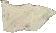

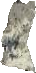

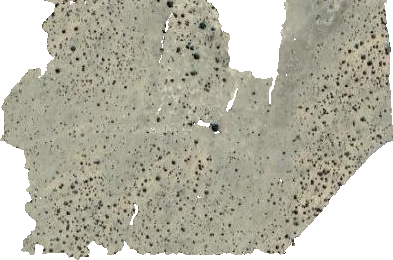

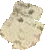

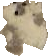

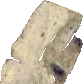

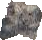

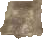

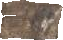

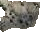

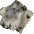

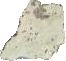

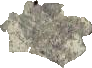

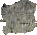

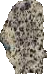

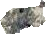

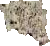

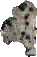

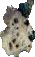

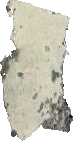

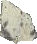

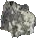

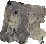

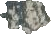

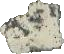

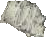

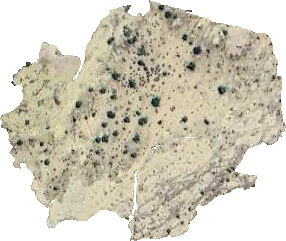

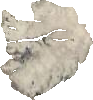

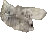

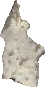

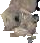

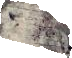

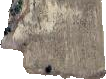

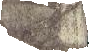

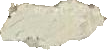

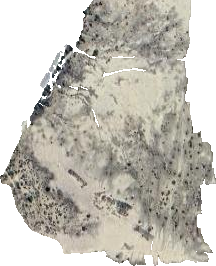

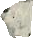

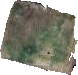

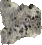

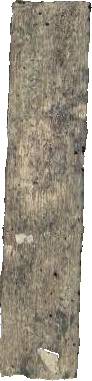

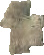

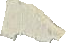

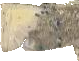

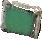

In [ ]:
for index, l in results.items():
    if l==2:
        img, mask, croping_indexes = crop_image_by_mask(image, index)
        if sum(sum(mask))>1000:
            img.show()
    if index ==5000:
        break
        

In [18]:
results

{1: ModeResult(mode=2, count=5),
 3: ModeResult(mode=2, count=5),
 4: ModeResult(mode=2, count=5),
 5: ModeResult(mode=2, count=5),
 6: ModeResult(mode=2, count=5),
 7: ModeResult(mode=2, count=4),
 8: ModeResult(mode=2, count=5),
 9: ModeResult(mode=2, count=5),
 10: ModeResult(mode=2, count=5),
 11: ModeResult(mode=2, count=5),
 12: ModeResult(mode=0, count=3),
 13: ModeResult(mode=0, count=4),
 14: ModeResult(mode=2, count=4),
 15: ModeResult(mode=2, count=5),
 16: ModeResult(mode=2, count=5),
 17: ModeResult(mode=2, count=5),
 18: ModeResult(mode=0, count=3),
 19: ModeResult(mode=2, count=5),
 20: ModeResult(mode=2, count=5),
 22: ModeResult(mode=2, count=5),
 23: ModeResult(mode=2, count=3),
 24: ModeResult(mode=2, count=5),
 25: ModeResult(mode=2, count=5),
 26: ModeResult(mode=2, count=5),
 27: ModeResult(mode=2, count=5),
 28: ModeResult(mode=2, count=3),
 29: ModeResult(mode=2, count=3),
 30: ModeResult(mode=2, count=3),
 31: ModeResult(mode=2, count=5),
 32: ModeResult(mode=0

In [11]:
nearest_labels

[2, 2, 2, 2, 2]

In [11]:
ts_image.shape

(872, 979, 23)